# Histopathologic Cancer Detection

This is for the [Kaggle Competition](https://www.kaggle.com/competitions/histopathologic-cancer-detection).

The target is creating an algorithm to identify metastatic cancer in small image patches taken from larger digital pathology scans. The data for this competition is a slightly modified version of the PatchCamelyon (PCam) benchmark dataset (the original PCam dataset contains duplicate images due to its probabilistic sampling, however, the version presented on Kaggle does not contain duplicates).

## Notebook Overview

This notebook implements a small image-classification pipeline for the Kaggle `Histopathologic Cancer Detection` competition (PCam). The main goals are:

- Load and inspect the dataset of small TIFF image patches (train / test).
- Build simple PyTorch datasets and data loaders with augmentation for robustness.
- Compare two compact CNN architectures (a Naive CNN and a CNN with simple residual-style concatenation).

## Dataset details

This cell documents the dataset layout and quick commands you can run to inspect counts and label balance:

Data layout (expected):
- `./.data/train/` — directory containing training TIFF images named with their `id` (e.g. `0000a1b2c30000a1b2c3.tif`).
- `./.data/test/` — directory containing test TIFF images for which predictions should be made.
- `./.data/train_labels.csv` — CSV with two columns: `id,label` where `label` is 0 (no tumor) or 1 (tumor).

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import torch
import torchvision
import PIL
from pathlib import Path
import torchsummary
import math
import tqdm


%matplotlib inline

### Transforms, normalization and input shape

Transforms applied in the notebook (summary):
- Training pipeline: Resize -> RandomHorizontalFlip -> RandomVerticalFlip -> RandomRotation -> ToTensor -> Normalize
- Validation/Test pipeline: Resize -> ToTensor -> Normalize

Normalization:
- The notebook uses ImageNet-like normalization values: mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225].

Input shape and batch shape:
- Images are resized to (48, 48). For a batch of size B, the tensor shape seen by the model is (B, 3, 48, 48).
- Note: The resizing aspects of this dataset is just for computation efficiency on my own laptop.

Augmentation Gotcha:
- For this dataset, rotatation, flipping, even some level of scaling are ok.
- Agressive Augmentation can make the learning process confusing at first glance. Meaning the training accuracy might become lower than validation accuracy.

## Loading Data and EDA

In [22]:
labels_df = pd.read_csv('.data/train_labels.csv')
labels_df['label'].value_counts()

label
0    130908
1     89117
Name: count, dtype: int64

In [23]:
train_image_dir = Path(".") / ".data" / "train"
f_image = next(train_image_dir.iterdir())
print("size of image: ", PIL.Image.open(f_image)._size)

whs = [
    PIL.Image.open(image_path)._size for image_path in train_image_dir.iterdir()
]
np.unique(whs)
print("All image has the same size")

size of image:  (96, 96)
All image has the same size


In [24]:
def plot_sample_imgs(samples, title):
    rows = 3
    cols = 10
    plt.subplots(rows, cols, figsize=(cols, rows))
    for i, smp in enumerate(samples[:rows * cols]):
        image_path = os.path.join(".data/train" , smp +'.tif')
        img = PIL.Image.open(image_path)
        PIL.ImageDraw.Draw(img)
        plt.subplot(rows, cols, i + 1) 
        plt.imshow(np.array(img))
        plt.axis('off')

    plt.suptitle(title)

### Malignant Image Plot

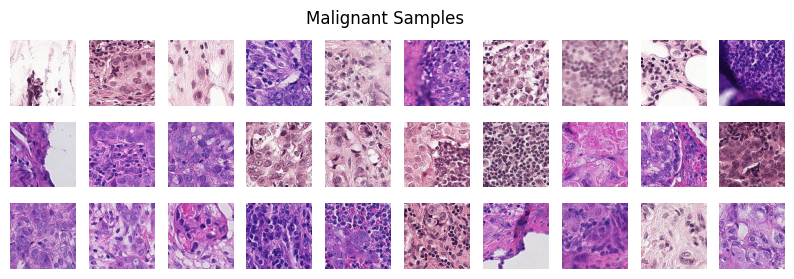

In [25]:
plot_sample_imgs(labels_df[labels_df['label']==1]['id'].values, "Malignant Samples")

### None Malignant Image Plot

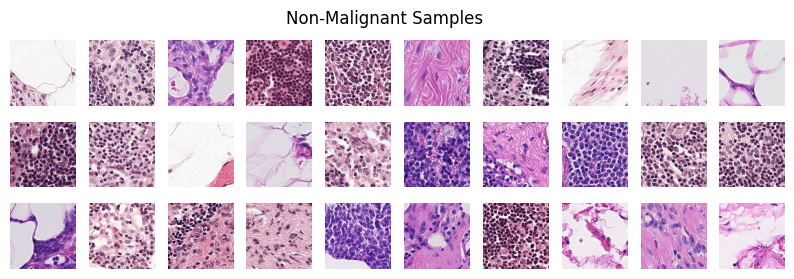

In [26]:
plot_sample_imgs(labels_df[labels_df['label']==0]['id'].values, "Non-Malignant Samples")

### Data Loaders & Data Preprocessing

In [95]:
class CancerImageDataset(torch.utils.data.Dataset):
    def __init__(self, transform: torchvision.transforms.Compose, size: int = -1):
        self.transform = transform

        data_path = Path("./.data")
        all_image_paths = list((data_path / "train").iterdir())  
        idx_choose = np.random.choice(
            np.arange(len(all_image_paths)), 
            size,
            replace=False
        ).tolist()
        self.sample_paths: list[Path] = [all_image_paths[x] for x in idx_choose]
        
        labels_df=pd.read_csv(data_path / "train_labels.csv")
        labels_df.set_index("id", inplace=True)
        self.sample_lables = [labels_df.loc[sample_path.stem].values[0] for sample_path in self.sample_paths]
      
    def __len__(self):
        return len(self.sample_paths)
      
    def __getitem__(self, i):
        return (
            self.transform(
                PIL.Image.open(self.sample_paths[i])
            ), 
            torch.nn.functional.one_hot(torch.tensor(self.sample_lables[i]), num_classes=2).to(torch.float)
        )

In [96]:
training_augments = torchvision.transforms.Compose([
    torchvision.transforms.Resize((48, 48)),
    torchvision.transforms.RandomHorizontalFlip(p=0.3), 
    torchvision.transforms.RandomVerticalFlip(p=0.3),  
    torchvision.transforms.RandomRotation(90),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
val_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((48, 48)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [97]:
train_ds = CancerImageDataset(training_augments, size=3000)
val_ds = CancerImageDataset(val_transform, size=750)

print("train set has samples:", len(train_ds))
print("validation set has samples:", len(val_ds))

train set has samples: 3000
validation set has samples: 750


In [98]:
image, label = train_ds[0]
print(image)
print(image.shape)
print(label)
print(label.shape)

tensor([[[-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         ...,
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179]],

        [[-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         ...,
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357]],

        [[-1.8044, -1.8044, -1.8044,  ..., -1.8044, -1.8044, -1.8044],
         [-1.8044, -1.8044, -1.8044,  ..., -1

In [99]:
BATCH_SIZE = 32
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_dl = torch.utils.data.DataLoader(val_ds, batch_size=BATCH_SIZE)

## Model Architecture & Training Exploration

### Training optimizations & hyperparameter search

This notebook uses several optimization choices and there are many reasonable hyperparameters to tune. 
Due to the resource I have, the hyperparameter search is done is manual manner.

Optimizations and settings used:
- Optimizer: AdamW.
- Scheduler: `ReduceLROnPlateau` (factor=0.5, patience=15) — reduces the learning rate when validation loss plateaus.
    - Some others has been tried as well including `StepLR`, and `CosineAnnealingLR` but these two are highly depends on the number of epochs. And hard to tune in small sample dataset. 
- Checkpointing: best-validation-accuracy model is saved during training.

Searched hyperparameter.
- Learning rate: try log-uniform sampling across [1e-5, 1e-3]. `ReduceLROnPlateau` allows us to start with some larger learning rate and decay later.
- Batch size: Doesn't matter much.
- Dropout (head): tried [0.0, 0.1, 0.2, 0.3] to combat overfitting.
- Architecture: channel multiplier C, `ff_hide_size` (e.g., 100, 200, 512), number of conv blocks.
- Augmentation strength: compare with/without rotation, and vary flip/rotation probabilities.

In [101]:
loss_function = torch.nn.CrossEntropyLoss()

In [ ]:
def calculate_accuracy(model, dataloader):
    model.eval()
    total_count = 0
    correct_count = 0
    with torch.no_grad():
        for data, labels in dataloader:
            logits: torch.Tensor = model(data)
            preds = logits.argmax(dim=1)
            trues = labels.argmax(dim=1)
            correct_count += (preds == trues).sum().item()
            total_count += labels.size(0)

    return correct_count / total_count if total_count > 0 else 0.0


def training_loop(
    model: torch.nn.Module, 
    train_data: torch.utils.data.DataLoader, 
    val_data: torch.utils.data.DataLoader, 
    epoch: int,
    model_saving_path: Path,
) -> tuple[list, list]:
    train_accuracy_hist = []
    val_accuracy_hist = []
    loss_hist = []
    best_val_acc = 0

    optimizer = torch.optim.AdamW(
        [{"params": model.parameters(), "lr": 5e-4}]
    )
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min',factor=0.5, patience=15)

    device = next(model.parameters()).device
    for ep in range(epoch):
        model.train()
        epoch_loss = 0.0
        for data, labels in train_data:
            data = data.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()

            logits: torch.Tensor = model(data)
            loss = loss_function(logits, labels)

            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        avg_epoch_loss = epoch_loss / len(train_data)
        scheduler.step(avg_epoch_loss)

        # compute accuracies (use eval mode inside helper)
        train_acc = calculate_accuracy(model, train_data)
        val_acc = calculate_accuracy(model, val_data)
        train_accuracy_hist.append(train_acc)
        val_accuracy_hist.append(val_acc)
        loss_hist.append(avg_epoch_loss)

        print(f"Epoch {ep} summary:")
        print(f" train_accuracy={train_acc}")
        print(f" val_accuracy={val_acc}")
        print(f" epoch_loss={avg_epoch_loss}")

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), model_saving_path)

    model.eval()
    model.load_state_dict(torch.load(model_saving_path, weights_only=False))

    return model, train_accuracy_hist, val_accuracy_hist, loss_hist

### Model architectures and design choices

Two compact convolutional architectures are implemented here to explore trade-offs between simplicity and representational capacity:

1) NaiveCNN
- A straightforward sequential stack of Conv2d layers with growing channel counts, ReLU activations, max pooling layers to downsample, then a small MLP head. This model is fast to run and easy to reason about.

2) CNNWithResidual
- A lightly residual-style model that concatenates earlier feature maps with later ones (increasing channel depth) and max pooling between stages. This concatenation is inspired by DenseNet-style feature reuse and helps gradient flow while keeping layer operations shallow.

Trade-offs and selection:
- The NaiveCNN is computationally cheaper and performed similarly on small experiments. The residual/concatenation model gives better feature reuse but costs more memory and compute.
- For the final run the notebook chooses the one with residual layers for a better performance.

### NaiveCNN

#### Expected layer shapes and flatten size (for input (3,48,48))

When using an input of shape (3, 48, 48) the NaiveCNN applies several conv+pool blocks. Below is a worked example of the intermediate feature-map sizes so you can reason about the model capacity and parameter counts:

Assuming the following sequential operations (Conv -> ReLU -> MaxPool2d(2)) repeated:
- Input: (3, 48, 48)
- After Conv(C->2C, kernel=3, padding=1) then MaxPool2d(2): (2C, 48, 48)
- After next Conv(2C->4C) then MaxPool2d(2): (4C, 24, 24)
- After next Conv(4C->8C) then MaxPool2d(2): (8C, 12, 12)
- After next Conv(8C->16C) then MaxPool2d(2): (16C, 6, 6)

In [100]:
class NaiveCNN(torch.nn.Module):
    def __init__(self, 
        input_shape: tuple[int, int, int],
        ff_hide_size: int,
        num_classes: int,
    ) -> None:
        super().__init__()
        C, W, H = input_shape

        self.cnn = torch.nn.Sequential(
            torch.nn.Conv2d(C, C*2, kernel_size=3, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2),
            torch.nn.Conv2d(C*2, C*4, kernel_size=3, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2),
            torch.nn.Conv2d(C*4, C*8, kernel_size=3, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2),
            torch.nn.Conv2d(C*8, C*16, kernel_size=3, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2),
            torch.nn.Flatten(1, -1),
            torch.nn.LazyLinear(ff_hide_size),
            torch.nn.Dropout(.2),
            torch.nn.ReLU(),
            torch.nn.Linear(ff_hide_size, num_classes),
        )
    
    def forward(self, in_data: torch.Tensor) -> torch.Tensor:
        return self.cnn(in_data)


In [103]:
CHECKPOINT_PATH = Path("./.checkpoint") / "naiveCNN"
CHECKPOINT_PATH.mkdir(exist_ok=True, parents=True)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = NaiveCNN((3, 48, 48), ff_hide_size=200, num_classes=2).to(device)
torchsummary.summary(model, input_size=(3, 48, 48), device=device.type)

model, train_acc_hist, val_acc_hist, loss_hist = training_loop(
    model, 
    train_dl, 
    val_dl, 
    epoch=50, 
    model_saving_path=CHECKPOINT_PATH / "weights.pt"
)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 48, 48]             168
              ReLU-2            [-1, 6, 48, 48]               0
         MaxPool2d-3            [-1, 6, 24, 24]               0
            Conv2d-4           [-1, 12, 24, 24]             660
              ReLU-5           [-1, 12, 24, 24]               0
         MaxPool2d-6           [-1, 12, 12, 12]               0
            Conv2d-7           [-1, 24, 12, 12]           2,616
              ReLU-8           [-1, 24, 12, 12]               0
         MaxPool2d-9             [-1, 24, 6, 6]               0
           Conv2d-10             [-1, 48, 6, 6]          10,416
             ReLU-11             [-1, 48, 6, 6]               0
        MaxPool2d-12             [-1, 48, 3, 3]               0
          Flatten-13                  [-1, 432]               0
           Linear-14                  [

Text(0, 0.5, 'Training Loss')

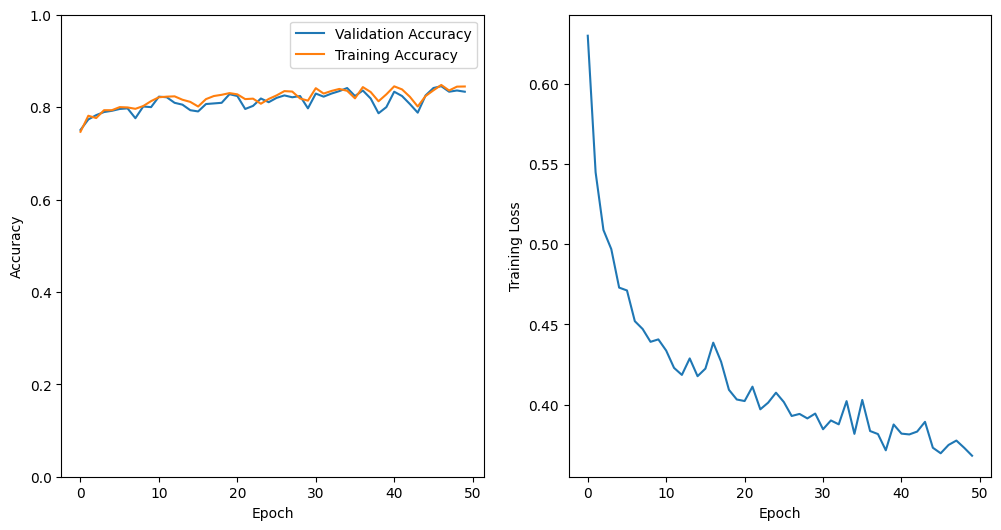

In [104]:
fig, axes = plt.subplots(1,2, figsize=(12,6))
axes[0].plot(range(0, len(val_acc_hist)), val_acc_hist, label="Validation Accuracy")
axes[0].plot(range(0, len(train_acc_hist)), train_acc_hist, label="Training Accuracy")

axes[1].plot(range(0, len(loss_hist)), loss_hist, label="Training Loss")

axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Accuracy")
axes[0].set_ylim(0, 1)
axes[0].legend()

axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Training Loss")

### CNN With Residual Layer

This model implements a lightweight residual/dense-style feature reuse pattern by concatenating earlier feature maps into later stages and downsampling between stages. Here are the main points:

Structure overview:
- The network is organized into 4 small convolutional blocks (`cnn1`..`cnn4`). Each block contains two 3x3 convolutions with ReLU activations.
- After each block the output is concatenated with the existing feature tensor along the channel dimension (like DenseNet-style feature aggregation).
- Spatial downsampling is done with pooling between concatenation stages so spatial resolution reduces while channel depth grows.
- The final `inference_head` flattens the features and passes them through a small MLP (LazyLinear -> ReLU -> Linear) to produce logits.

Why this helps:
- Feature reuse: concatenating earlier features makes low-level details available to deeper layers. This can improve gradient flow and give the model access to multi-scale information without extremely deep stacking.
- Parameter efficiency: shallow blocks with concatenation can sometimes match deeper networks in representational power for small inputs like 48x48 patches.

In [105]:
class CNNWithResidual(torch.nn.Module):
    def __init__(self, 
        input_shape: tuple[int, int, int],
        ff_hide_size: int,
        num_classes: int,
    ) -> None:
        super().__init__()
        C, W, H = input_shape

        self.cnn1 = torch.nn.Sequential(
            torch.nn.Conv2d(C, C*2, kernel_size=3, padding=1),
            torch.nn.ReLU(),
            torch.nn.Conv2d(C*2, C*2, kernel_size=3, padding=1),
            torch.nn.ReLU(),
        )
        self.cnn2 = torch.nn.Sequential(
            torch.nn.Conv2d(C*2 + C, C*4, kernel_size=3, padding=1),
            torch.nn.ReLU(),
            torch.nn.Conv2d(C*4, C*4, kernel_size=3, padding=1),
            torch.nn.ReLU(),
        )
        self.cnn3 = torch.nn.Sequential(
            torch.nn.Conv2d(C*4 + C*2 + C, C*8, kernel_size=3, padding=1),
            torch.nn.ReLU(),
            torch.nn.Conv2d(C*8, C*8, kernel_size=3, padding=1),
            torch.nn.ReLU(),
        )
        self.cnn4 = torch.nn.Sequential(
            torch.nn.Conv2d(C*8 + C*4 + C*2 + C, C*16, kernel_size=3, padding=1),
            torch.nn.ReLU(),
            torch.nn.Conv2d(C*16, C*16, kernel_size=3, padding=1),
            torch.nn.ReLU(),
        )

        self.inference_head = torch.nn.Sequential(
            torch.nn.Flatten(1, -1),
            torch.nn.LazyLinear(ff_hide_size),
            torch.nn.Dropout(.1),
            torch.nn.ReLU(),
            torch.nn.Linear(ff_hide_size, num_classes),
        )
    
    def forward(self, in_data: torch.Tensor) -> torch.Tensor:
        hid: torch.Tensor = in_data
        max_pool = torch.nn.MaxPool2d(2)

        hid = torch.cat((hid, self.cnn1(hid)), dim=1)
        hid = max_pool(hid)
        hid = torch.cat((hid, self.cnn2(hid)), dim=1)
        hid = max_pool(hid)
        hid = torch.cat((hid, self.cnn3(hid)), dim=1)
        hid = max_pool(hid)
        hid = torch.cat((hid, self.cnn4(hid)), dim=1)
        hid = max_pool(hid)

        return self.inference_head(hid)

In [106]:
CHECKPOINT_PATH = Path("./.checkpoint") / "CNNWithResidual"
CHECKPOINT_PATH.mkdir(exist_ok=True, parents=True)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CNNWithResidual((3, 48, 48), ff_hide_size=200, num_classes=2).to(device)
torchsummary.summary(model, input_size=(3, 48, 48), device=device.type)

model, train_acc_hist, val_acc_hist, loss_hist = training_loop(
    model, 
    train_dl, 
    val_dl, 
    epoch=50, 
    model_saving_path=CHECKPOINT_PATH / "weights.pt"
)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 48, 48]             168
              ReLU-2            [-1, 6, 48, 48]               0
            Conv2d-3            [-1, 6, 48, 48]             330
              ReLU-4            [-1, 6, 48, 48]               0
            Conv2d-5           [-1, 12, 24, 24]             984
              ReLU-6           [-1, 12, 24, 24]               0
            Conv2d-7           [-1, 12, 24, 24]           1,308
              ReLU-8           [-1, 12, 24, 24]               0
            Conv2d-9           [-1, 24, 12, 12]           4,560
             ReLU-10           [-1, 24, 12, 12]               0
           Conv2d-11           [-1, 24, 12, 12]           5,208
             ReLU-12           [-1, 24, 12, 12]               0
           Conv2d-13             [-1, 48, 6, 6]          19,488
             ReLU-14             [-1, 4

Text(0, 0.5, 'Training Loss')

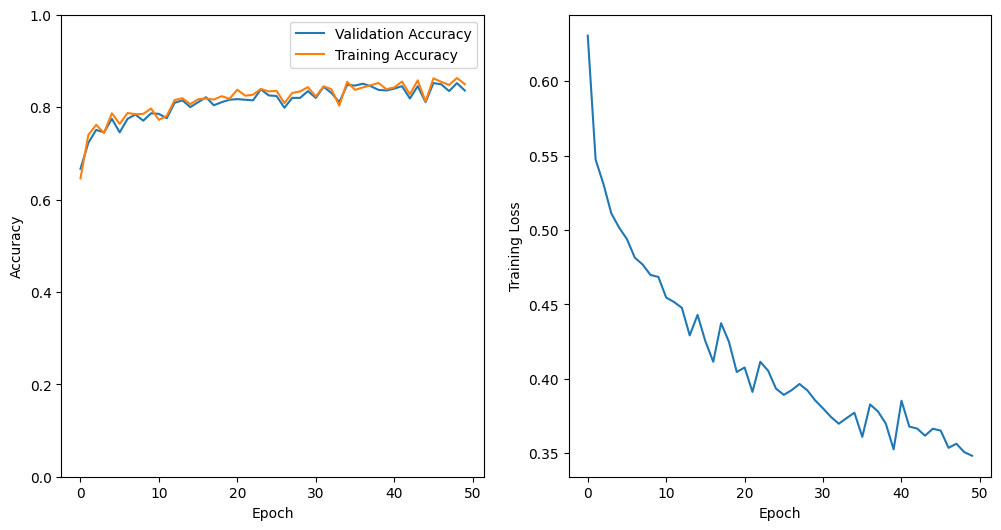

In [107]:
fig, axes = plt.subplots(1,2, figsize=(12,6))
axes[0].plot(range(0, len(val_acc_hist)), val_acc_hist, label="Validation Accuracy")
axes[0].plot(range(0, len(train_acc_hist)), train_acc_hist, label="Training Accuracy")

axes[1].plot(range(0, len(loss_hist)), loss_hist, label="Training Loss")

axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Accuracy")
axes[0].set_ylim(0, 1)
axes[0].legend()

axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Training Loss")

### Architecture Selection

The Model with Residual Layer injected has a better accuracy somehow 86% comparing to 84% (Training on 50 epoches with 3000 samples).

Lets go ahead use the model with residual layer for final model. To save my laptop some more life. I would use 30000 of the training sample for this final model training, instead of all.

In [108]:
all_train_ds = CancerImageDataset(training_augments, size=30000)
all_val_ds = CancerImageDataset(val_transform, size=3000)

BATCH_SIZE = 32
all_train_dl = torch.utils.data.DataLoader(all_train_ds, batch_size=BATCH_SIZE, shuffle=True)
all_val_dl = torch.utils.data.DataLoader(all_val_ds, batch_size=BATCH_SIZE)

In [109]:
CHECKPOINT_PATH = Path("./.checkpoint") / "Final"
CHECKPOINT_PATH.mkdir(exist_ok=True, parents=True)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = NaiveCNN((3, 48, 48), ff_hide_size=200, num_classes=2).to(device)
torchsummary.summary(model, input_size=(3, 48, 48), device=device.type)

model, train_acc_hist, val_acc_hist, loss_hist = training_loop(
    model, 
    all_train_dl, 
    all_val_dl, 
    epoch=100, 
    model_saving_path=CHECKPOINT_PATH / "weights.pt"
)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 48, 48]             168
              ReLU-2            [-1, 6, 48, 48]               0
         MaxPool2d-3            [-1, 6, 24, 24]               0
            Conv2d-4           [-1, 12, 24, 24]             660
              ReLU-5           [-1, 12, 24, 24]               0
         MaxPool2d-6           [-1, 12, 12, 12]               0
            Conv2d-7           [-1, 24, 12, 12]           2,616
              ReLU-8           [-1, 24, 12, 12]               0
         MaxPool2d-9             [-1, 24, 6, 6]               0
           Conv2d-10             [-1, 48, 6, 6]          10,416
             ReLU-11             [-1, 48, 6, 6]               0
        MaxPool2d-12             [-1, 48, 3, 3]               0
          Flatten-13                  [-1, 432]               0
           Linear-14                  [

In [110]:
def predict_test_data(model):
    test_image_dir = Path(".") / ".data" / "test"
    submission_path = Path("my_submission.csv")

    with submission_path.open('w') as file:
        file.writelines("id,label\n")
        for img in test_image_dir.iterdir():
            img_ts = val_transform(PIL.Image.open(img))

            logits: torch.Tensor = model(img_ts.unsqueeze(0))
            label = logits.argmax(dim=1)[0]
            file.write(f"{img.stem},{label}\n")
    

In [111]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CNNWithResidual((3, 48, 48), ff_hide_size=200, num_classes=2).to(device)
model.load_state_dict(torch.load(Path("./.checkpoint") / "CNNWithResidual" / "weights.pt", weights_only=False))
predict_test_data(model)

### Summary

The model achieved a 0.81 AUC on kaggel. 

To improve this:
- Use (96, 96) size of images and all sample data to train the model (Although this will kill my laptop).
- Try some architecture like GoogleNet, to use different Level of information for each layer.
- Use AUC instead of accuracy for training indicator.